# SARIMA Forecasting


Seasonal Autoregressive Integrated Moving Average Model (p,d,q)x(P,D,Q,s)

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

S: Seasonal components incorporated into the dataset, such as seasonal lag and residual error terms 

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


More information can be found here https://365datascience.com/wp-content/uploads/2020/07/SARIMAX-.pdf

In [1]:
\l ../tm.q
.tm.loadfile`:init.q
\l ../utils.q

This is an SARIMA model implementation using purely kdb

## Daily Temp

### Data Preparation

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - December 1990.

Null values are removed from the dataset

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any nulls from the data
mintemp:delete from mintemp where temp=0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


The data is plotted below to portray the trends and cycles present in the dataset

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


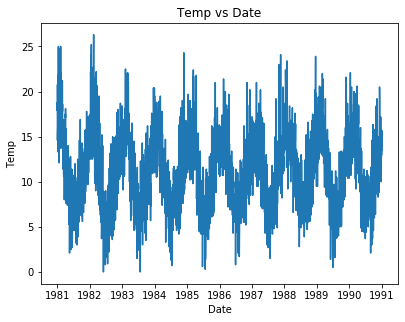

In [3]:
plttm[mintemp`date;mintemp`temp;"Temp"]

Missing timestamp values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [4]:
mintemp:datefill[`date;mintemp;1D]


// back and forward fill data
mintemp:.ml.filltab[mintemp;();`date;::]

dt:mintemp`date
// Timestamp component is broken into its constituent parts
mintemp:.ml.timesplit[mintemp;`date] 

// Back and forward fill the missing data
mintemp:.ml.dropconstant[mintemp]

In [5]:
// Delete any null_ cols - too many 0 values for model to preform well
delcols:cols[mintemp] where cols[mintemp] like"*_null"

mintemp:![mintemp;();0b;delcols]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data. The x are defined as the inputs and temperature as the target values

In [6]:
// Find the timestamp which splits the data 80/20
tts:ttstm[delete temp from mintemp;mintemp`temp;.2]

// The data is then split into the training and testing sets
xtraintmp:tts`xtrain
ytraintmp:tts`ytrain
xtesttmp:tts`xtest
ytesttmp:tts`ytest

-1!"There is ",string[count xtraintmp]," datapoints in the training set"
-1!"There is ",string[count xtesttmp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


### Training the model

Compared to the ARIMA model, the SARIMA model has an additional parameter `s` which indicates the seasonality components to include when building the model. This includes `P`, the seasonal lag value, `D`, the seasonal differencing value and `Q`, the seasonal error term. The periodicy of the seasonal component `m` is also included. For example, if the data was hourly, a periodicy of 24 could be used (assuming that the data is equispaced

The inputs to the SARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)
s        | Dictionary with seasonal P,D,Q and m(periodicy) values
        
It is evident that the data is not stationary, therefor a `d` value of 1 will be passed to the model

As this is daily data with a yearly cyclical pattern, a seasonality of 365 days (rows) was used. It is assumed that each row in the data is equally spaced apart.

In [7]:
show s:`P`D`Q`m!2 0 1 365

P| 2
D| 0
Q| 1
m| 365


In [8]:
\t show smdl:.tm.SARIMAfit[ytraintmp;xtraintmp;3;0;1;1b;s]

params    | -113.8548 -0.03496998 0.05703393 0.05762212 -0.0001742072 -0.0592..
tr_param  | -113.8548
exog_param| -0.03496998 0.05703393 0.05762212 -0.0001742072 -0.05923344 0.352..
p_param   | 0.09037849 -0.4194947 1.096884
q_param   | ,-0.5185234
P_param   | 0.1846998 0.0491017
Q_param   | ,-0.1846998
lags      | 13.2 11.7 17.2 12.3 13.8 15.3 15.6 16.2 16.3 16.8 11 8.5 13.2 13 ..
resid     | 3.380189 -0.1089798 0.09268168 -0.2113732 1.065321 -1.0219 1.8393..
estresid  | -0.05562385 0.0009808693 0.03540751 0.003727848 -0.213247 0.37683..
pred_dict | `p`q`P`Q`m`tr`seas_add_P`seas_add_Q`n!(3;1;0 365;,0;365;1b;1 2 3 ..
origd     | `float$()
origs     | `float$()


298


The keys of the returned dictionary to be used for forcasting

key      |  Explanation
---------------|---------------------------
params      | model paramaters for future predictions
tr_param    | trend paramaters
exog_param | exog paramaters
p_param    | lag value paramaters
q_param     | error paramaters
P_param    | seasonal lag value paramaters
Q_param     | seasonal error paramaters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid     | Coefficients used to estimate resid errors
origd        | Original values of input values before being differenciated
origs        | Original values to be used to transform seasonal differencing to original format

### Model Forecasting

The inputs to `.tm.SARIMApred` are 

The inputs to the SARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .tm.SARIMAfit
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast

and returns the predicted values

In [9]:
\t predstmp:.tm.SARIMApred[smdl;xtesttmp;count xtesttmp]

// Calculate the error
-1!"The Mean squared error is ",string .ml.rmsle[predstmp;ytesttmp]

33


"The Mean squared error is 0.3171566"


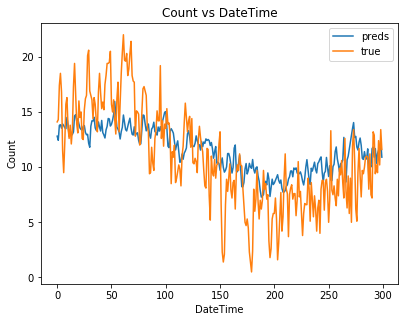

In [10]:
pltresult[300#predstmp;300#ytesttmp;"Count"]

Compared to the ARIMA model, it is evident that adding seasonal components greatly improved the results of the model.

## Bike Rental

**In this section a more complex model is used with exogenous variables included in the training of the models**

### Data Preparation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [11]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset



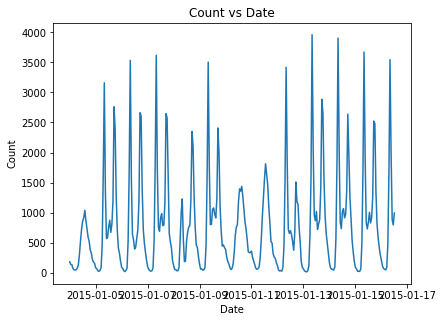

In [12]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]


Missing timestamps values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [13]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Timestamp component is broken into its constituent parts
bikes:.ml.timesplit[bikes;`timestamp] 

-1"\nThe new timestamp columns created include:\n";
string -9#cols[bikes]


// Back and forward fill the missing data
bikes:.ml.dropconstant[.ml.filltab[bikes;();`timestamp;::]]


The new timestamp columns created include:



"timestamp_dow"
"timestamp_year"
"timestamp_mm"
"timestamp_dd"
"timestamp_qtr"
"timestamp_wd"
"timestamp_hh"
"timestamp_uu"
"timestamp_ss"


In [14]:
// Delete any null_ cols - too many 0 values for model to preform well
delcols:cols[bikes] where cols[bikes] like"*_null"

bikes:![bikes;();0b;delcols]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In this scenario, the exogeneous columns are used as the input data, and bike count as the target data



In [15]:
// Find the timestamp which splits the data 80/20
tts:ttstm[delete cnt from bikes;bikes`cnt;0.2]

// The data is then split into the training and testing sets
xtrainbk:tts`xtrain
ytrainbk:tts`ytrain
xtestbk:tts`xtest
ytestbk:tts`ytest


-1!"There is ",string[count xtrainbk]," datapoints in the training set"
-1!"There is ",string[count xtestbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


### Training the model


#### Building the model

Compared to the ARIMA model, the SARIMA model has an additional parameter `s` which indicates the seasonality components to include when building the model. This includes `P`, the seasonal lag value, `D`, the seasonal differencing value and `Q`, the seasonal error term. The periodicy of the seasonal component `m` is also included. For example, if the data was hourly, a periodicy of 24 could be used (assuming that the data is equispaced

The inputs to the SARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)
s        | Dictionary with seasonal P,D,Q and m(periodicy) values

        
The data looks stationary, therefor no `d` component will be included in the model.
 
As this is hourly data, a seasonality component of 168 (24*7 days) was implemented. It was assumed that each row in the data is equally spaced apart in time

In [21]:
show s:`P`D`Q`m!1 0 1 168

P| 1
D| 0
Q| 1
m| 168


In [22]:
\t show smdl:.tm.SARIMAfit[ytrainbk;xtrainbk;3;0;1;1b;s]

params    | 5770.591 0.0692153 -0.02571103 0.00814089 0.9686802 -13.17298 59...
tr_param  | 5770.591
exog_param| 0.0692153 -0.02571103 0.00814089 0.9686802 -13.17298 59.53023 -1...
p_param   | 0.1732129 -0.5520961 1.213868
q_param   | ,-0.1904198
P_param   | ,0.82065
Q_param   | ,-0.82065
lags      | 2519 4601 4712 3029 1911 1280 975 697 308 176 119 54 56 148 759 2..
resid     | 281.1759 -263.4011 132.2193 5.831679 58.5959 -332.9467 -244.6208 ..
estresid  | 41.05569 -13.11611 -10.98317 -3.984604 -6.34628 -49.31474 9.05547..
pred_dict | `p`q`P`Q`m`tr`seas_add_P`seas_add_Q`n!(3;1;,0;,0;168;1b;1 2 3;,1;4)
origd     | `float$()
origs     | `float$()


18822


The keys of the returned dictionary to be used for forcasting

key      |  Explanation
---------------|---------------------------
params      | model paramaters for future predictions
tr_param    | trend paramaters
exog_param | exog paramaters
p_param    | lag value paramaters
q_param     | error paramaters
P_param    | seasonal lag value paramaters
Q_param     | seasonal error paramaters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid     | Coefficients used to estimate resid errors
origd        | Original values of input values before being differenciated
origs        | Original values to be used to transform seasonal differencing to original format

### Model Forecasting

The future values are forecasted using the `forecast` feature of the fitted model.

The forecasted values are used to calculated the associated error


The inputs to `.tm.SARIMApred` are 

The inputs to the SARIMAfit:

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .tm.SARIMAfit (dictionary)
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast (int)

and returns the predicted values

In [23]:
\t predsbk:.tm.SARIMApred[smdl;xtestbk;1000]

// Calculate the error
-1!"The Root mean squared log error is ",string .ml.rmsle[predsbk;1000#ytestbk]

35


"The Root mean squared log error is 1.452315"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values



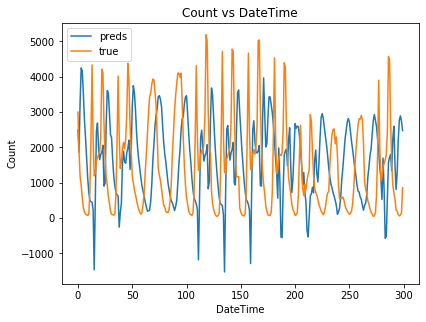

In [24]:
pltresult[300#predsbk;300#ytestbk;"Count"]

Unlike the above example, adding seasonal components did not improve the results of the model and instead increased the error